Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [8]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [9]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [11]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    hidden_layer_size = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]))
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)

    output_weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
    output_biases = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(hidden_layer, output_weights) + output_biases

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    l2_regularizer = tf.nn.l2_loss(output_weights) + tf.nn.l2_loss(hidden_weights)
    loss += 5e-4 * l2_regularizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    # Setup validation prediction step.
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_logits = tf.matmul(valid_hidden, output_weights) + output_biases
    valid_prediction = tf.nn.softmax(valid_logits)

    # And setup the test prediction step.
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_logits = tf.matmul(test_hidden, output_weights) + output_biases
    test_prediction = tf.nn.softmax(test_logits)

Initialized
Minibatch loss at step 0: 512.509277
Minibatch accuracy: 5.5%
Validation accuracy: 34.4%
Test accuracy: 37.1%
Minibatch loss at step 500: 133.451141
Minibatch accuracy: 83.6%
Validation accuracy: 76.9%
Test accuracy: 83.7%
Minibatch loss at step 1000: 96.278862
Minibatch accuracy: 80.5%
Validation accuracy: 81.6%
Test accuracy: 87.9%
Minibatch loss at step 1500: 74.026848
Minibatch accuracy: 86.7%
Validation accuracy: 82.2%
Test accuracy: 89.0%
Minibatch loss at step 2000: 56.333527
Minibatch accuracy: 89.8%
Validation accuracy: 83.1%
Test accuracy: 90.0%
Minibatch loss at step 2500: 44.041615
Minibatch accuracy: 83.6%
Validation accuracy: 83.1%
Test accuracy: 90.6%
Minibatch loss at step 3000: 34.088036
Minibatch accuracy: 83.6%
Validation accuracy: 84.5%
Test accuracy: 91.5%
  Test accuracy: 91.5%


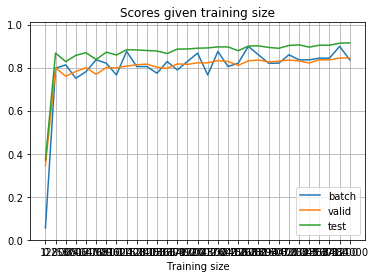

In [12]:
num_steps = 3001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % batch_score)
                print("Validation accuracy: %.1f%%" % valid_score)
                print("Test accuracy: %.1f%%" % test_score)
            result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
    print("  Test accuracy: %.1f%%" % test_score)
    
"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [13]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    hidden_layer_size = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]))
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)

    output_weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
    output_biases = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(hidden_layer, output_weights) + output_biases

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    l2_regularizer = tf.nn.l2_loss(output_weights) + tf.nn.l2_loss(hidden_weights)
    loss += 5e-4 * l2_regularizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    # Setup validation prediction step.
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_logits = tf.matmul(valid_hidden, output_weights) + output_biases
    valid_prediction = tf.nn.softmax(valid_logits)

    # And setup the test prediction step.
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_logits = tf.matmul(test_hidden, output_weights) + output_biases
    test_prediction = tf.nn.softmax(test_logits)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 495.490021
Minibatch accuracy: 4.7%
Validation accuracy: 33.6%
Test accuracy: 37.1%
Minibatch loss at step 500: 122.412384
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Test accuracy: 83.9%
Minibatch loss at step 1000: 95.331894
Minibatch accuracy: 100.0%
Validation accuracy: 76.7%
Test accuracy: 84.0%
Minibatch loss at step 1500: 74.242096
Minibatch accuracy: 100.0%
Validation accuracy: 76.7%
Test accuracy: 84.0%
Minibatch loss at step 2000: 57.818153
Minibatch accuracy: 100.0%
Validation accuracy: 76.7%
Test accuracy: 84.0%
Minibatch loss at step 2500: 45.027313
Minibatch accuracy: 100.0%
Validation accuracy: 76.7%
Test accuracy: 83.9%
Minibatch loss at step 3000: 35.066254
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Test accuracy: 83.9%
  Test accuracy: 83.9%


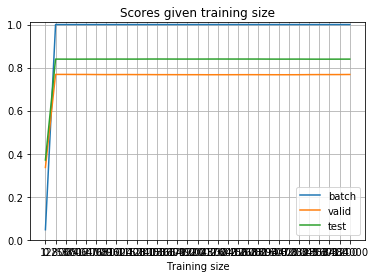

In [14]:
num_steps = 3001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = batch_size * np.random.choice(np.arange(5))
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % batch_score)
                print("Validation accuracy: %.1f%%" % valid_score)
                print("Test accuracy: %.1f%%" % test_score)
            result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
    print("  Test accuracy: %.1f%%" % test_score)
    
"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [15]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    hidden_layer_size = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]))
    hidden_layer = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases), 0.5)

    output_weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
    output_biases = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(hidden_layer, output_weights) + output_biases

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    # Setup validation prediction step.
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_logits = tf.matmul(valid_hidden, output_weights) + output_biases
    valid_prediction = tf.nn.softmax(valid_logits)

    # And setup the test prediction step.
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_logits = tf.matmul(test_hidden, output_weights) + output_biases
    test_prediction = tf.nn.softmax(test_logits)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 422.980225
Minibatch accuracy: 9.4%
Validation accuracy: 36.5%
Test accuracy: 39.9%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 78.7%
Test accuracy: 86.2%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.1%
Test accuracy: 86.3%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Test accuracy: 86.2%
Test accuracy: 86.2%


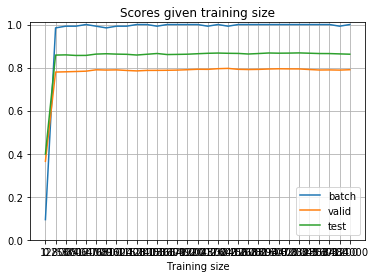

In [16]:
num_steps = 3001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = batch_size * np.random.choice(np.arange(5))
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            if (step % 1000 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % batch_score)
                print("Validation accuracy: %.1f%%" % valid_score)
                print("Test accuracy: %.1f%%" % test_score)
            result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
    print("Test accuracy: %.1f%%" % test_score)
    
"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [17]:
batch_size = 128
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 512
num_hidden_nodes_3 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes_1], 
                           stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))

    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2],
                          stddev=np.sqrt(2.0 / num_hidden_nodes_1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3],
                          stddev=np.sqrt(2.0 / num_hidden_nodes_2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))
    
    output_weights = tf.Variable(tf.truncated_normal([num_hidden_nodes_3, num_labels],
                                stddev=np.sqrt(2.0 / num_hidden_nodes_3)))
    output_biases = tf.Variable(tf.zeros([num_labels]))
    
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(layer1_train, 0.5)
    layer2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(layer2_train, 0.5)
    layer3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
    drop3 = tf.nn.dropout(layer3_train, 0.5)
    logits = tf.matmul(drop3, output_weights) + output_biases  
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    train_prediction = tf.nn.softmax(logits)
    # Setup validation prediction step.
    valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_hidden2 = tf.nn.relu(tf.matmul(valid_hidden1, weights2) + biases2)
    valid_hidden3 = tf.nn.relu(tf.matmul(valid_hidden2, weights3) + biases3)
    valid_logits = tf.matmul(valid_hidden3, output_weights) + output_biases
    valid_prediction = tf.nn.softmax(valid_logits)

    # And setup the test prediction step.
    test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_hidden2 = tf.nn.relu(tf.matmul(test_hidden1, weights2) + biases2)
    test_hidden3 = tf.nn.relu(tf.matmul(test_hidden2, weights3) + biases3)
    test_logits = tf.matmul(test_hidden3, output_weights) + output_biases
    test_prediction = tf.nn.softmax(test_logits)
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.870701
Minibatch accuracy: 9.4%
Validation accuracy: 26.5%
Test accuracy: 28.0%
Minibatch loss at step 1000: 0.614621
Minibatch accuracy: 79.7%
Validation accuracy: 84.7%
Test accuracy: 91.8%
Minibatch loss at step 2000: 0.343320
Minibatch accuracy: 93.8%
Validation accuracy: 86.0%
Test accuracy: 92.7%
Minibatch loss at step 3000: 0.526512
Minibatch accuracy: 82.0%
Validation accuracy: 86.3%
Test accuracy: 93.2%
Minibatch loss at step 4000: 0.419788
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%
Test accuracy: 93.8%
Minibatch loss at step 5000: 0.453588
Minibatch accuracy: 87.5%
Validation accuracy: 87.9%
Test accuracy: 94.0%
Minibatch loss at step 6000: 0.476684
Minibatch accuracy: 84.4%
Validation accuracy: 88.2%
Test accuracy: 94.4%
Minibatch loss at step 7000: 0.537407
Minibatch accuracy: 85.9%
Validation accuracy: 88.5%
Test accuracy: 94.7%
Minibatch loss at step

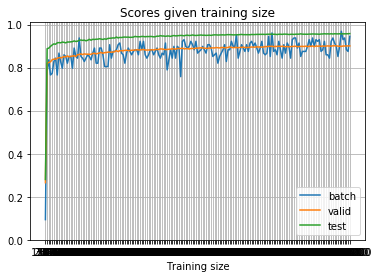

In [18]:
num_steps = 18001
result_data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #offset = batch_size * np.random.choice(np.arange(5))
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            if (step % 1000 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % batch_score)
                print("Validation accuracy: %.1f%%" % valid_score)
                print("Test accuracy: %.1f%%" % test_score)
            result_data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
    print("Test accuracy: %.1f%%" % test_score)
    
"""
Plot results
"""
fig, ax = plt.subplots()
ax.plot(result_data[:,0], result_data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(result_data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()
plt.show()